In [1]:
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
from collections.abc import Iterable
random.seed(42)
torch.manual_seed(42)
device=("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
batch_size=64
img_size=224
p_dim=768
num_encoder=11

In [3]:
def files(main_dir):
    images,labels=[],[]
    for cat in os.listdir(main_dir):
        for file in os.listdir(os.path.join(main_dir,cat)):
            images.append(os.path.join(main_dir,cat,file))
            labels.append(cat)
    return images,labels

In [4]:
main_dir='/kaggle/input/potato-plant-diseases-data/PlantVillage/PlantVillage'
images,labels=files(main_dir)
images[:5],labels[:5]

(['/kaggle/input/potato-plant-diseases-data/PlantVillage/PlantVillage/Potato___healthy/7948ada9-eabc-4cb7-a579-b73e938eb716___RS_HL 4185.JPG',
  '/kaggle/input/potato-plant-diseases-data/PlantVillage/PlantVillage/Potato___healthy/f5bd2732-197b-4d8e-bb50-a4966dc416f5___RS_HL 1840.JPG',
  '/kaggle/input/potato-plant-diseases-data/PlantVillage/PlantVillage/Potato___healthy/5a3fc4bb-a78c-4276-8934-f0b037ffb860___RS_HL 5412.JPG',
  '/kaggle/input/potato-plant-diseases-data/PlantVillage/PlantVillage/Potato___healthy/875d6ded-5f01-495c-a945-ad2e17f87f91___RS_HL 1848.JPG',
  '/kaggle/input/potato-plant-diseases-data/PlantVillage/PlantVillage/Potato___healthy/4ae82355-6885-40e7-9807-dabe46ed3441___RS_HL 5410.JPG'],
 ['Potato___healthy',
  'Potato___healthy',
  'Potato___healthy',
  'Potato___healthy',
  'Potato___healthy'])

In [5]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(np.array(images),np.array(labels),test_size=0.2,random_state=42)
x_test,x_valid,y_test,y_valid=train_test_split(x_test,y_test,test_size=0.5,random_state=42)
x_train.shape,x_test.shape,x_valid.shape,y_train.shape,y_test.shape,y_valid.shape

((1721,), (215,), (216,), (1721,), (215,), (216,))

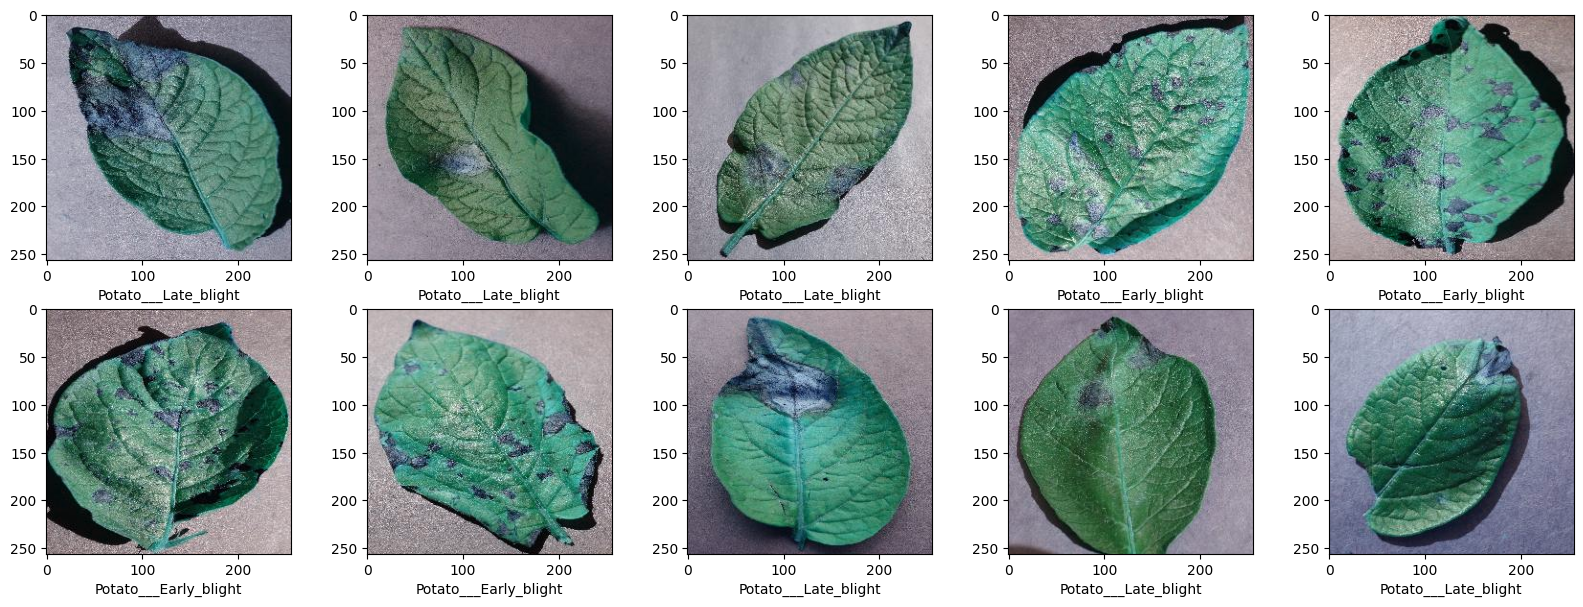

In [6]:
_, ax = plt.subplots(2, 5, figsize=(20,7))
for i in range(10):
    index=random.randint(0,len(x_train))
    img=cv2.imread(x_train[index])
    ax[i//5,i%5].imshow(img)
    ax[i//5,i%5].set_xlabel(y_train[index])

In [7]:
def image_preprocessing(path):
    img=cv2.imread(path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2LAB)
    clahe=cv2.createCLAHE(tileGridSize=(8,8),clipLimit=1)
    img[:,:,0]=clahe.apply(img[:,:,0])
    img=cv2.cvtColor(img,cv2.COLOR_LAB2RGB)
    img=cv2.resize(img,(img_size,img_size),interpolation=cv2.INTER_LINEAR)
    img=(img/255.0).astype(np.float32)
    img=np.moveaxis(img,-1,0)
    return img

In [8]:
x_train=np.array(list(map(image_preprocessing,x_train)))
x_valid=np.array(list(map(image_preprocessing,x_valid)))
x_test=np.array(list(map(image_preprocessing,x_test)))
x_train.shape,x_valid.shape,x_test.shape

((1721, 3, 224, 224), (216, 3, 224, 224), (215, 3, 224, 224))

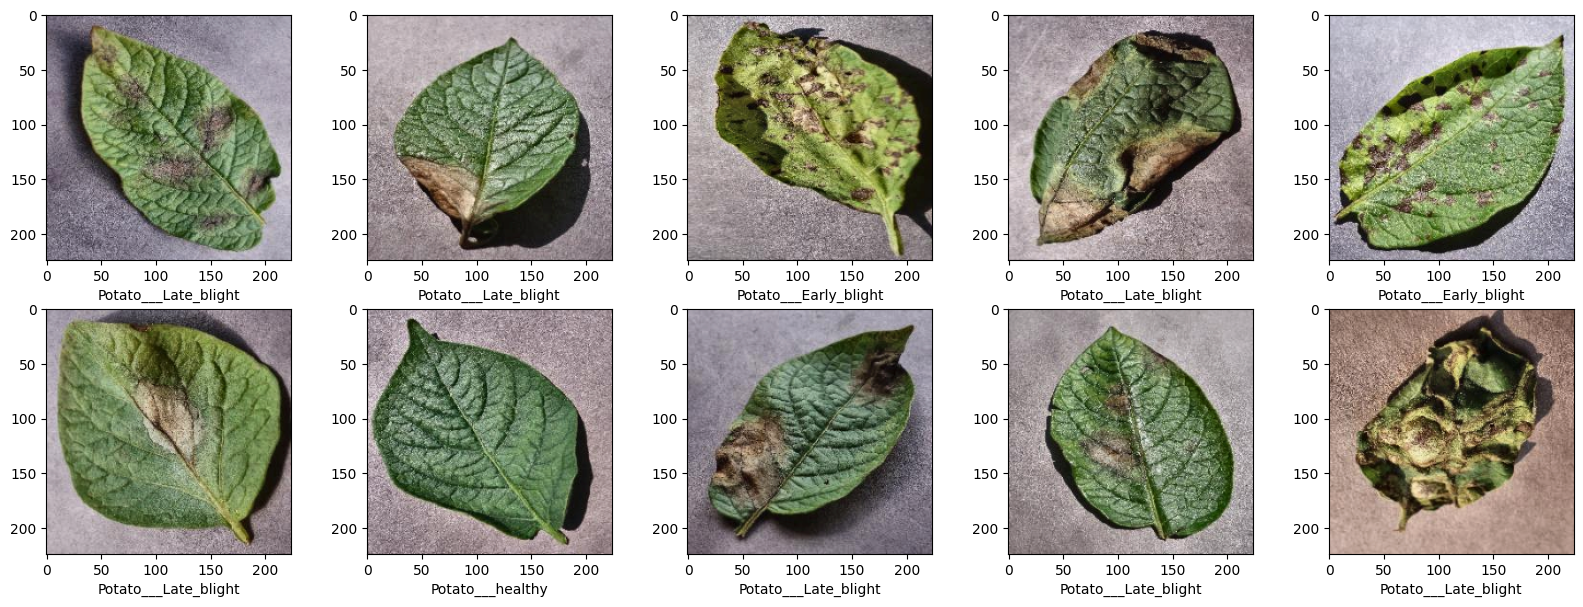

In [9]:
_, ax = plt.subplots(2, 5, figsize=(20,7))
for i in range(10):
    index=random.randint(0,len(x_train))
    img=np.moveaxis(x_train[index],0,-1)
    ax[i//5,i%5].imshow((img*255).astype('uint8'))
    ax[i//5,i%5].set_xlabel(y_train[index])

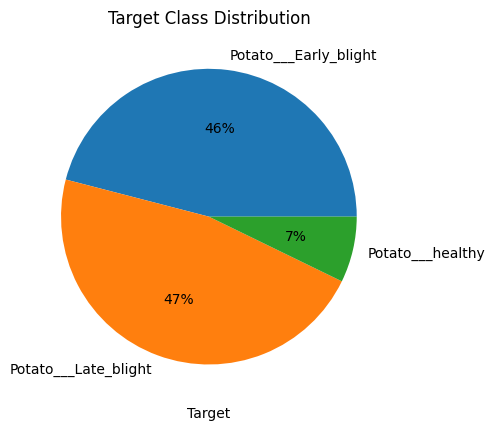

In [10]:
unique,count=np.unique(y_train,return_counts=True)
plt.pie(x=count,labels=unique,autopct='%.0f%%')
plt.xlabel('Target')
plt.title('Target Class Distribution')
plt.show()

In [11]:
from sklearn.preprocessing import LabelBinarizer
encoder=LabelBinarizer()
y_train=encoder.fit_transform(y_train)
y_valid=encoder.transform(y_valid)
y_test=encoder.transform(y_test)
y_train.shape,y_valid.shape,y_test.shape

((1721, 3), (216, 3), (215, 3))

In [12]:
class StandardScaler():
    def __init__(self) -> None:
        self.mean=None
        self.std=None
        
    def fit(self,tensor:np.ndarray) -> None:
        tensor=tensor.astype(np.float32)
        self.mean=np.mean(tensor,axis=(0,2,3),keepdims=True)
        self.std=np.std(tensor,axis=(0,2,3),keepdims=True)
        
    def transform(self,tensor:np.ndarray) -> np.ndarray:
        scaled=(tensor-self.mean)/(self.std)
        return scaled.astype(np.float32)
    
    def fit_transform(self,tensor:np.ndarray) -> np.ndarray:
        self.fit(tensor=tensor)
        scaled=self.transform(tensor=tensor)
        return scaled

In [13]:
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)
x_valid=scaler.transform(x_valid)
scaler.mean,scaler.std

(array([[[[0.52219343]],
 
         [[0.53563577]],
 
         [[0.4554962 ]]]], dtype=float32),
 array([[[[0.19358563]],
 
         [[0.1795793 ]],
 
         [[0.2165559 ]]]], dtype=float32))

In [14]:
from torch.utils.data import TensorDataset, DataLoader

In [15]:
def loading_data(x,y,shuffle):
    x=torch.from_numpy(x.copy()).to(device)
    y=torch.from_numpy(y.copy()).to(device)
    dataset=TensorDataset(x,y)
    dataloader=DataLoader(dataset,batch_size=batch_size,shuffle=shuffle)
    return dataloader

In [16]:
train_loader=loading_data(x_train,y_train,True)
val_loader=loading_data(x_valid,y_valid,False)
test_loader=loading_data(x_test,y_test,False)

In [17]:
class Conv2DNormAct(torch.nn.Module):
    def __init__(self,in_chan:int,out_chan:int,kernel:int,stride:int) -> None:
        super().__init__()
        self.block=torch.nn.Sequential(
            torch.nn.Conv2d(in_chan,out_chan,kernel,stride,1),
            torch.nn.BatchNorm2d(out_chan),
            torch.nn.ReLU()
        )
    def forward(self,x):
        return self.block(x)

In [18]:
class ConvStem(torch.nn.Module):
    def __init__(self, 
                 in_chan:Iterable[int], 
                 out_chan:Iterable[int], 
                 kernels:Iterable[int], 
                 strides:Iterable[int], 
                 dim:int) -> None:
        super().__init__()
        self.dim=dim
        self.stem=torch.nn.Sequential()
        for i in range(len(in_chan)):
            self.stem.add_module(f'conv_bn_act_{i}',Conv2DNormAct(in_chan[i],out_chan[i],kernels[i],strides[i]))
        self.stem.add_module('identity_conv',torch.nn.Conv2d(out_chan[-1],dim,1))
    def forward(self,x:torch.Tensor):
        h:torch.Tensor=self.stem(x)
        return h

In [19]:
class RNN(torch.nn.Module):
    def __init__(self, num_inputs, num_hiddens, sigma):
        super().__init__()
        self.num_hiddens=num_hiddens
        self.W_xh = torch.nn.Parameter(
            torch.randn(num_inputs, num_hiddens) * sigma
        )
        self.W_hh = torch.nn.Parameter(
            torch.randn(num_hiddens, num_hiddens) * sigma
        )
        self.b_h = torch.nn.Parameter(torch.zeros(num_hiddens))
        self.Lambda=torch.nn.Parameter(torch.tensor(0.5))
        self.sigmoid=torch.nn.Sigmoid()
    def forward(self,inputs):
        inputs=inputs.transpose(0,1)
        state = torch.zeros((inputs.shape[1], self.num_hiddens),device=inputs.device)
        outputs=[]
        for x in inputs:
            state = (1-self.sigmoid(self.Lambda))*torch.matmul(x, self.W_xh)+self.sigmoid(self.Lambda)*torch.matmul(state, self.W_hh) + self.b_h
            outputs.append(state)
        outputs=torch.stack(outputs).transpose(1,0)
        return outputs,state

In [20]:
class EncoderBlock(torch.nn.Module):
    def __init__(self, projection_dim:int, dropout:float):
        super().__init__()
        self.projection_dim=projection_dim

        self.norm1=torch.nn.LayerNorm(self.projection_dim)
        self.norm2=torch.nn.LayerNorm(self.projection_dim)
        self.rnn=RNN(self.projection_dim,self.projection_dim,0.01)
        self.mlp=torch.nn.Sequential(
            torch.nn.Linear(self.projection_dim,self.projection_dim*4),
            torch.nn.Dropout(dropout),
            torch.nn.GELU(),
            torch.nn.Linear(self.projection_dim*4,self.projection_dim),
            torch.nn.Dropout(dropout)
        )

    def forward(self,x):
        x1=self.norm1(x)
        seq,state=self.rnn(x1)
        x2=seq+x
        x3=self.norm2(x2)
        x3=self.mlp(x3)
        out=x2+x3
        return out

In [21]:
class Model(torch.nn.Module):
    def __init__(self,
                 projection_dim:int,
                 num_encoder:int,
                 dropout:float):
        super().__init__()
        self.projection_dim=projection_dim
        self.num_encoder=num_encoder
        
        self.conv_stem=ConvStem([3, 64, 128, 128, 256, 256],
                                [64, 128, 128, 256, 256, 512],
                                [3]*6,
                                [2,2,1,2,1,2],
                                self.projection_dim)
        self.blocks = torch.nn.ModuleList([
            EncoderBlock(self.projection_dim,
                         dropout) for _ in range(self.num_encoder)
        ])
        self.ln_out=torch.nn.LayerNorm(self.projection_dim)
        
        self.out=torch.nn.Sequential(
            torch.nn.Linear(self.projection_dim,len(encoder.classes_))
        )
    def forward(self,images:torch.Tensor):
        batch_size=images.size()[0]
        x=self.conv_stem(images).reshape(batch_size,
                                         self.projection_dim,
                                         -1).permute(0, 2, 1)
        encoded=x
        for i,block in enumerate(self.blocks):
            encoded=block(encoded)
        
        rep=encoded.mean(dim=1)
        rep=self.ln_out(rep)
        output=self.out(rep)
        return output

In [22]:
model=Model(projection_dim=p_dim,
            num_encoder=num_encoder,
            dropout=0.3)
model=torch.nn.DataParallel(model).to(device)
print(model)

DataParallel(
  (module): Model(
    (conv_stem): ConvStem(
      (stem): Sequential(
        (conv_bn_act_0): Conv2DNormAct(
          (block): Sequential(
            (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (conv_bn_act_1): Conv2DNormAct(
          (block): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (conv_bn_act_2): Conv2DNormAct(
          (block): Sequential(
            (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (conv_bn_ac

In [23]:
total_params = sum(p.numel() for p in model.parameters())
print('Total model parameters: ', total_params)

Total model parameters:  67654286


In [24]:
class Trainer():
    def __init__(self, 
                 model, 
                 loss_fn, 
                 T, 
                 init_lr, 
                 min_lr, 
                 optimizer, 
                 wd) -> None:
        assert optimizer in ['adamw','sgd'], 'Only support SGD or AdamW'
        self.model=model
        opt_choice={'adamw':torch.optim.AdamW(self.model.parameters(),
                                              lr=init_lr,
                                              weight_decay=wd),
                    'sgd':torch.optim.SGD(self.model.parameters(),
                                          lr=init_lr,weight_decay=wd,
                                          momentum=0.9)}
        self.opt=opt_choice[optimizer]
        self.sch=torch.optim.lr_scheduler.CosineAnnealingLR(self.opt,T,min_lr)
        self.loss_fn=loss_fn
        self.history={'losses':[], 
                      'val_losses':[]}
        
    def __trainstep(self,train_loader: DataLoader, verbose: int):
        self.model.train()
        train_loss=0
        batches=len(train_loader)
        if verbose == 1:
            train_loader=tqdm(train_loader)
        for x,y in train_loader:
            pred=self.model(x)
            loss=self.loss_fn(pred,y.float())
            if verbose==1:
                train_loader.set_postfix({'loss':loss.item()})
            train_loss+=loss.item()
            loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        train_loss/=batches
        self.history['losses'].append(train_loss)
        return train_loss

    def __evalstep(self, val_loader: DataLoader,verbose: int):
        self.model.eval()
        val_loss=0
        batches=len(val_loader)
        if verbose == 1:
            val_loader=tqdm(val_loader)
        with torch.no_grad():
            for x,y in val_loader:
                pred=self.model(x)
                loss=self.loss_fn(pred,y.float())
                if verbose==1:
                    val_loader.set_postfix({'val_loss':loss.item()})
                val_loss+=loss.item()
        val_loss/=batches
        self.history['val_losses'].append(val_loss)
        return val_loss

    def fit(self, train_loader: DataLoader, 
            val_loader: DataLoader, 
            epochs: int, 
            verbose: int, 
            patience: int):
        assert verbose in [0,1], 'verbose must be either 0 or 1'
        best_loss = float('inf')
        best_model = None
        max_patience=patience
        for i in range(epochs):
            if verbose == 1:
                print(f'\nEpoch: {i+1}')
            train_loss=self.__trainstep(train_loader, verbose)
            val_loss=self.__evalstep(val_loader, verbose)
            if verbose == 1:
                print(f'mean loss: {train_loss}')
                print(f'mean validation loss: {val_loss}')
            if self.history['val_losses'][-1] - best_loss < 1e-6:
                best_loss=self.history['val_losses'][-1]
                best_model=self.model.state_dict()
                patience+=1
            else:
                patience-=1
                if patience == 0:
                    break
            if self.sch:
                self.sch.step()
        self.model.load_state_dict(best_model)
        if verbose == 1:
            print(f'\nbest loss:', best_loss)
            
    def predict(self, test_loader: DataLoader):
        self.model.eval()
        test_preds=[]
        with torch.no_grad():
            for x in test_loader:
                pred=self.model(x[0])
                pred=torch.nn.Softmax(dim=1)(pred)
                test_preds.append(pred.cpu().numpy())
        test_preds=np.concatenate(test_preds,axis=0)
        return test_preds

In [25]:
trainer=Trainer(model=model,
                loss_fn=torch.nn.CrossEntropyLoss(),
                T=100,
                init_lr=1e-4,
                min_lr=1e-7,
                optimizer='adamw',
                wd=0.24)

In [26]:
trainer.fit(train_loader=train_loader,
            val_loader=val_loader,
            epochs=100,
            verbose=1,
            patience=10)


Epoch: 1


100%|██████████| 4/4 [00:02<00:00,  1.73it/s, val_loss=2.14]


mean loss: 1.169167791251783
mean validation loss: 2.343303382396698

Epoch: 2


100%|██████████| 4/4 [00:02<00:00,  1.74it/s, val_loss=0.359]


mean loss: 0.37067037103352724
mean validation loss: 0.349813811480999

Epoch: 3


100%|██████████| 4/4 [00:02<00:00,  1.74it/s, val_loss=0.39]


mean loss: 0.18766427536805472
mean validation loss: 0.6616776660084724

Epoch: 4


100%|██████████| 4/4 [00:02<00:00,  1.72it/s, val_loss=0.112]


mean loss: 0.12321620489712115
mean validation loss: 0.18305727653205395

Epoch: 5


100%|██████████| 4/4 [00:02<00:00,  1.63it/s, val_loss=0.0098]


mean loss: 0.10003616536657016
mean validation loss: 0.0804584315046668

Epoch: 6


100%|██████████| 4/4 [00:02<00:00,  1.67it/s, val_loss=0.0299]


mean loss: 0.09506155557378575
mean validation loss: 0.06635939795523882

Epoch: 7


100%|██████████| 4/4 [00:02<00:00,  1.75it/s, val_loss=0.0172]


mean loss: 0.10462560049361652
mean validation loss: 0.04409897746518254

Epoch: 8


100%|██████████| 4/4 [00:02<00:00,  1.76it/s, val_loss=0.0114]


mean loss: 0.07349570537054981
mean validation loss: 0.06745312409475446

Epoch: 9


100%|██████████| 4/4 [00:02<00:00,  1.73it/s, val_loss=0.0438]


mean loss: 0.05615595904075437
mean validation loss: 0.06846077181398869

Epoch: 10


100%|██████████| 4/4 [00:02<00:00,  1.73it/s, val_loss=0.111]


mean loss: 0.06788945815491455
mean validation loss: 0.13343432545661926

Epoch: 11


100%|██████████| 4/4 [00:02<00:00,  1.76it/s, val_loss=0.06]


mean loss: 0.061522764446972696
mean validation loss: 0.11003470234572887

Epoch: 12


100%|██████████| 4/4 [00:02<00:00,  1.71it/s, val_loss=0.0343]


mean loss: 0.04568138846230728
mean validation loss: 0.059308579191565514

Epoch: 13


100%|██████████| 4/4 [00:02<00:00,  1.69it/s, val_loss=0.0109]


mean loss: 0.03559200163861668
mean validation loss: 0.041424044873565435

Epoch: 14


100%|██████████| 4/4 [00:02<00:00,  1.53it/s, val_loss=0.382]


mean loss: 0.04592096149335029
mean validation loss: 0.32041284441947937

Epoch: 15


100%|██████████| 4/4 [00:02<00:00,  1.70it/s, val_loss=0.0146]


mean loss: 0.061919200923983696
mean validation loss: 0.04799710935913026

Epoch: 16


100%|██████████| 4/4 [00:02<00:00,  1.72it/s, val_loss=0.0605]


mean loss: 0.04764674804863279
mean validation loss: 0.05618064198642969

Epoch: 17


100%|██████████| 4/4 [00:02<00:00,  1.72it/s, val_loss=0.00362]


mean loss: 0.04164020062631203
mean validation loss: 0.03035196429118514

Epoch: 18


100%|██████████| 4/4 [00:02<00:00,  1.67it/s, val_loss=0.00496]


mean loss: 0.028284799092000833
mean validation loss: 0.034421016462147236

Epoch: 19


100%|██████████| 4/4 [00:02<00:00,  1.74it/s, val_loss=0.283]


mean loss: 0.022993565394750073
mean validation loss: 0.16608985140919685

Epoch: 20


100%|██████████| 4/4 [00:02<00:00,  1.73it/s, val_loss=0.0456]


mean loss: 0.025732540068458074
mean validation loss: 0.04863686766475439

Epoch: 21


100%|██████████| 4/4 [00:02<00:00,  1.73it/s, val_loss=0.0114]


mean loss: 0.03345164960181272
mean validation loss: 0.04320225352421403

Epoch: 22


100%|██████████| 4/4 [00:02<00:00,  1.75it/s, val_loss=0.0179]


mean loss: 0.04080972645897418
mean validation loss: 0.021279082517139614

Epoch: 23


100%|██████████| 4/4 [00:02<00:00,  1.74it/s, val_loss=0.138]


mean loss: 0.017888780295227964
mean validation loss: 0.08888249844312668

Epoch: 24


100%|██████████| 4/4 [00:02<00:00,  1.78it/s, val_loss=0.0457]


mean loss: 0.01924592054328295
mean validation loss: 0.05473304935730994

Epoch: 25


100%|██████████| 4/4 [00:02<00:00,  1.72it/s, val_loss=0.0935]


mean loss: 0.011699182841564633
mean validation loss: 0.04896913934499025

Epoch: 26


100%|██████████| 4/4 [00:02<00:00,  1.75it/s, val_loss=0.0121]


mean loss: 0.01320526438239203
mean validation loss: 0.017370630346704274

Epoch: 27


100%|██████████| 4/4 [00:02<00:00,  1.77it/s, val_loss=0.359]


mean loss: 0.015514697049554714
mean validation loss: 0.1961595881730318

Epoch: 28


100%|██████████| 4/4 [00:02<00:00,  1.75it/s, val_loss=0.00166]


mean loss: 0.019688410154129896
mean validation loss: 0.026330460532335564

Epoch: 29


100%|██████████| 4/4 [00:02<00:00,  1.73it/s, val_loss=0.0232]


mean loss: 0.008609441818272764
mean validation loss: 0.09359042067080736

Epoch: 30


100%|██████████| 4/4 [00:02<00:00,  1.69it/s, val_loss=0.0234]

mean loss: 0.01977558763852964
mean validation loss: 0.0698606614023447

best loss: 0.017370630346704274


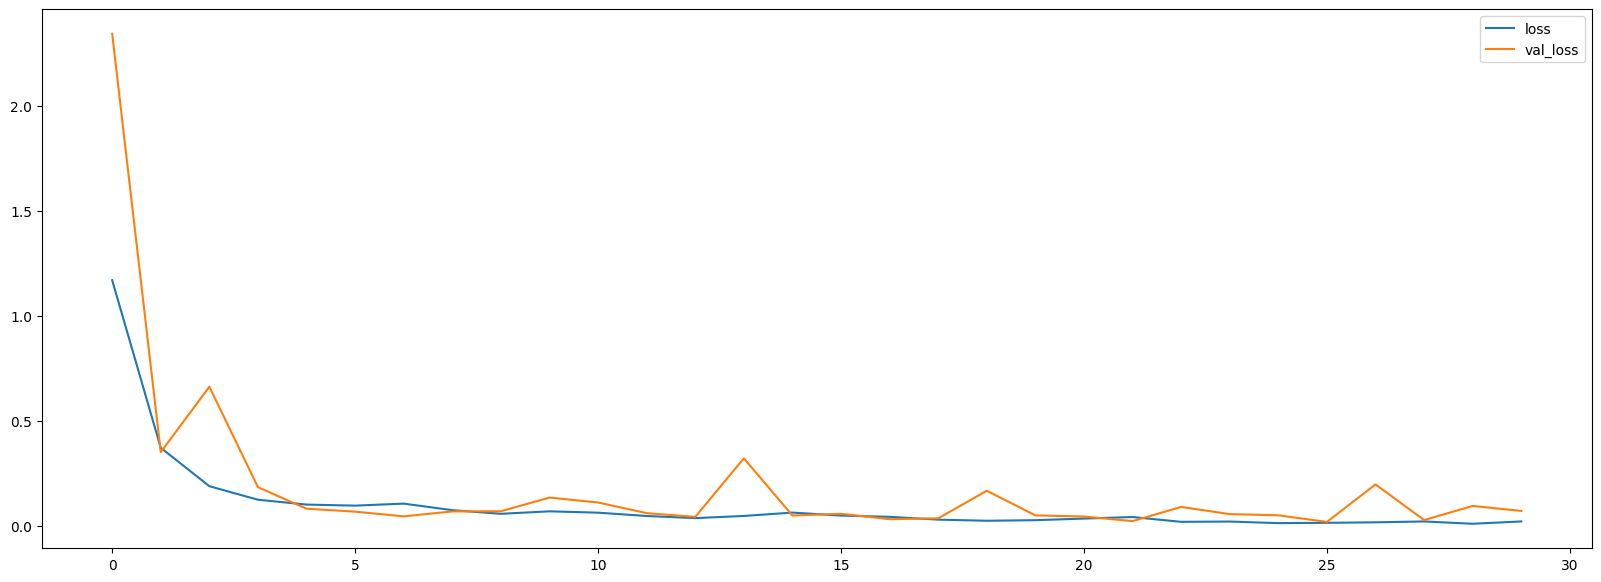

In [27]:
losses=trainer.history['losses']
val_losses=trainer.history['val_losses']
plt.figure(figsize=(20, 7))
plt.plot(range(len(losses)),losses)
plt.plot(range(len(val_losses)),val_losses)
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

In [28]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

def evaluation_parametrics(name, y_val, y_pred):
    
    print("\n------------------------{}------------------------\n".format(name))
    y_val1=encoder.inverse_transform(y_val)
    y_pred1=encoder.inverse_transform(y_pred)
    cm_test = confusion_matrix(y_val1, y_pred1)    
    print("\nClassification Report\n")
    print(classification_report(y_val, y_pred,target_names=encoder.classes_))   
    print("--------------------------------------------------------------------------")
    plt.figure(figsize=(16, 14))
    sns.heatmap(cm_test,annot=True,fmt='g',xticklabels=encoder.classes_,yticklabels=encoder.classes_)
    plt.show()


------------------------Confusion Matrix - Validation Dataset------------------------


Classification Report

                       precision    recall  f1-score   support

Potato___Early_blight       0.99      0.98      0.99       105
 Potato___Late_blight       0.98      0.99      0.98        99
     Potato___healthy       0.92      0.92      0.92        12

            micro avg       0.98      0.98      0.98       216
            macro avg       0.96      0.96      0.96       216
         weighted avg       0.98      0.98      0.98       216
          samples avg       0.98      0.98      0.98       216

--------------------------------------------------------------------------


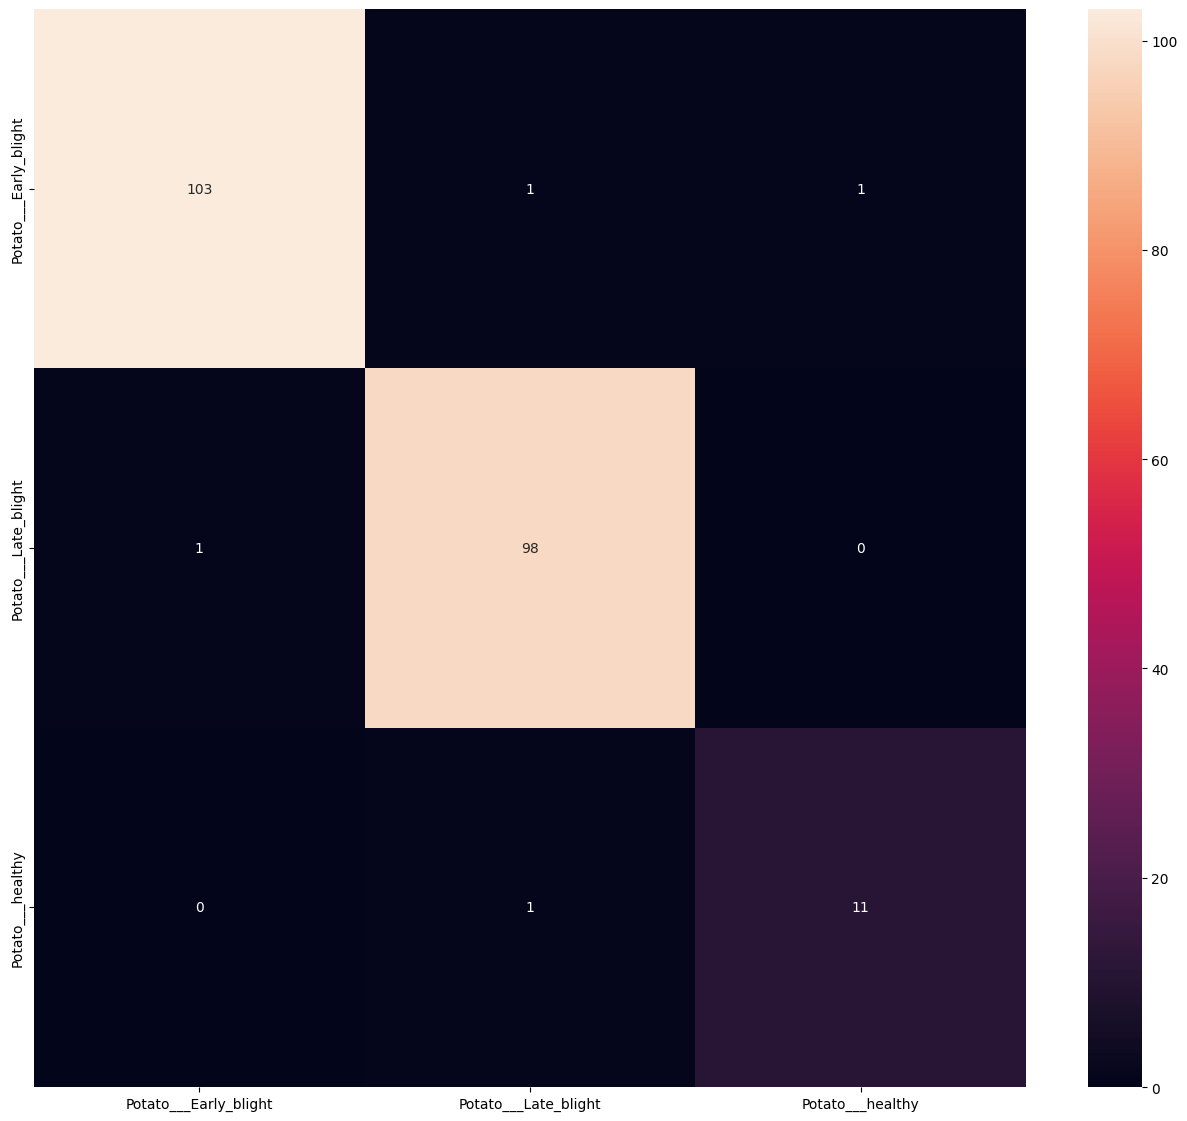

In [29]:
evaluation_parametrics("Confusion Matrix - Validation Dataset", y_valid, np.round(trainer.predict(val_loader)))


------------------------Confusion Matrix - Test Dataset------------------------


Classification Report

                       precision    recall  f1-score   support

Potato___Early_blight       0.99      0.99      0.99       104
 Potato___Late_blight       0.99      0.96      0.97        95
     Potato___healthy       0.79      0.94      0.86        16

            micro avg       0.97      0.97      0.97       215
            macro avg       0.92      0.96      0.94       215
         weighted avg       0.97      0.97      0.97       215
          samples avg       0.97      0.97      0.97       215

--------------------------------------------------------------------------


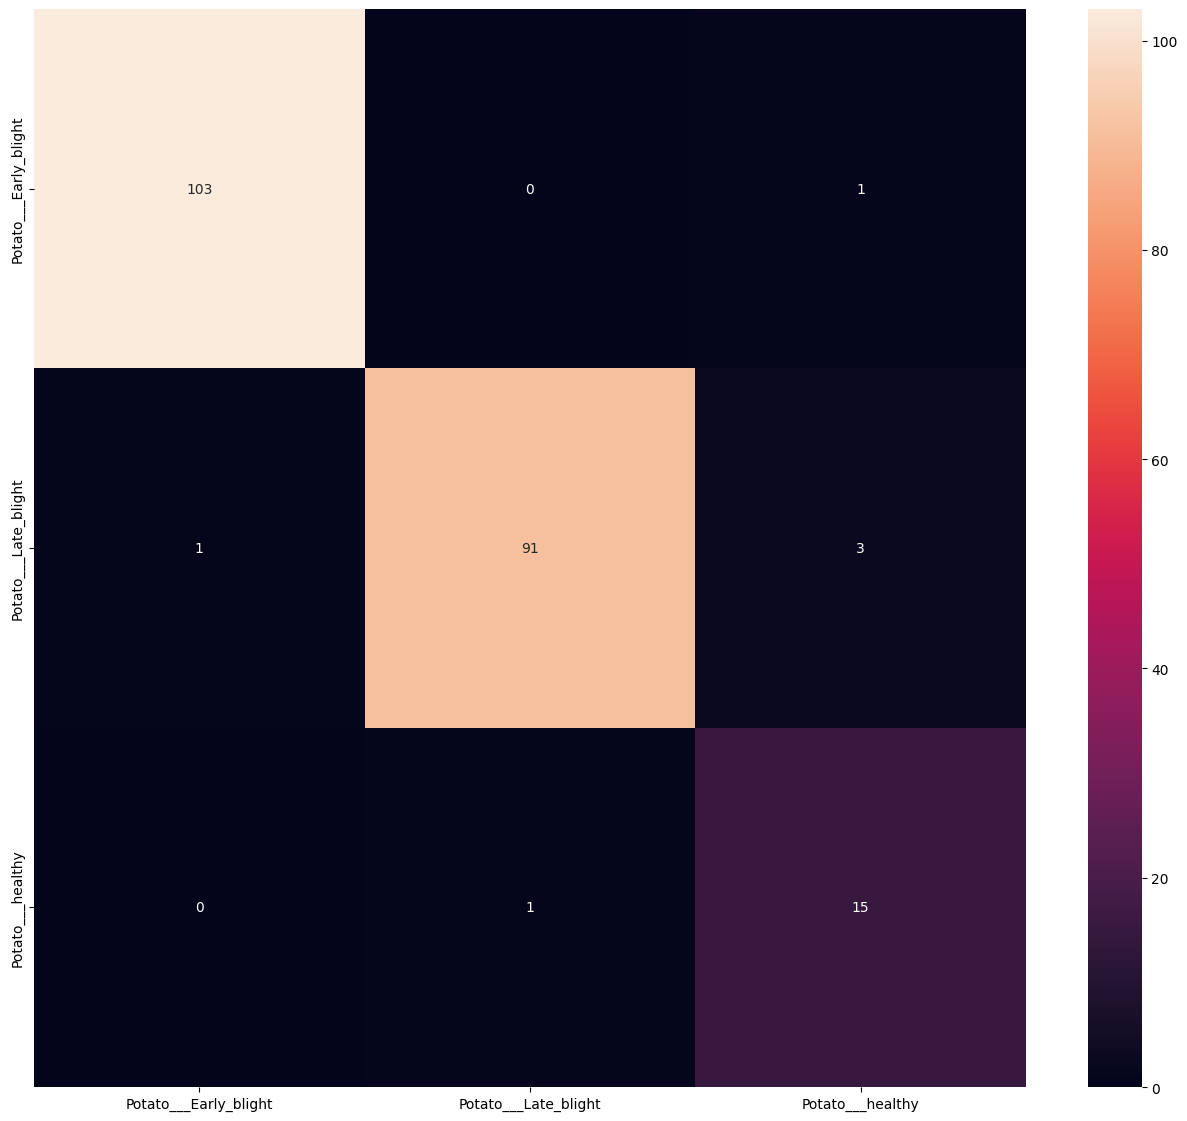

In [30]:
evaluation_parametrics("Confusion Matrix - Test Dataset", y_test, np.round(trainer.predict(test_loader)))